# House Prices - Advanced Regression Techniques
## Exploratory Data Analysis
## Trevor Johnson

<br>

### Goal:
Predict sales price for each house (`SalePrice`). RMSE on log(pred) - log(actual) will be the evaluation metric. Final submission dataset should contain only the two fields `ID` and `SalePrice`. 

# Setups

Load libraries and read in the data

In [496]:
# libraries
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from patsy import dmatrices
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.formula.api import glm 

In [476]:
# set directory and read in the data
os.chdir("/Users/tj/Desktop/data/housing")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
sample = pd.read_csv("sample_submission.csv")

# Initial Exploration

Size of training and testing data.

In [477]:
print("train shape: {}".format(train.shape))
print("test shape: {}".format(test.shape))

train shape: (1460, 81)
test shape: (1459, 80)


Check for missing values. Some variables have mostly missing values.

In [478]:
train.isnull().sum()[train.isnull().sum() != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [479]:
# deal with missing values, can alter this later

def na_clean(df):
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["FireplaceQu", "PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df[var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df[var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df['MasVnrType'].fillna('None', inplace = True)
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['MSZoning'].fillna('RL', inplace = True)
    df['SaleType'].fillna('WD', inplace = True)
    df['Utilities'].fillna('AllPub', inplace = True)
    df['KitchenQual'].fillna('TA', inplace = True)
    df['Functional'].fillna('Typ', inplace = True)

    # other cat vars just put missing if there isn't a glaring most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd']
    for var in replace_missing_vars:
        df[var].fillna("Missing", inplace = True)

    return df

train = na_clean(train)
test = na_clean(test)


In [480]:
# no more missing values!
print("Missing values in train: {}".format(train.isnull().sum().sum()))
print("Missing values in test: {}".format(test.isnull().sum().sum()))

Missing values in train: 0
Missing values in test: 0


In [481]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [482]:
# some data cleaning
train = train.rename(columns = {"1stFlrSF": "FirstFlrSF", "2ndFlrSF": "SecondFlrSF", "3SsnPorch": "SsnPorch"})
test = test.rename(columns = {"1stFlrSF": "FirstFlrSF", "2ndFlrSF": "SecondFlrSF", "3SsnPorch": "SsnPorch"})

## Data Visualization

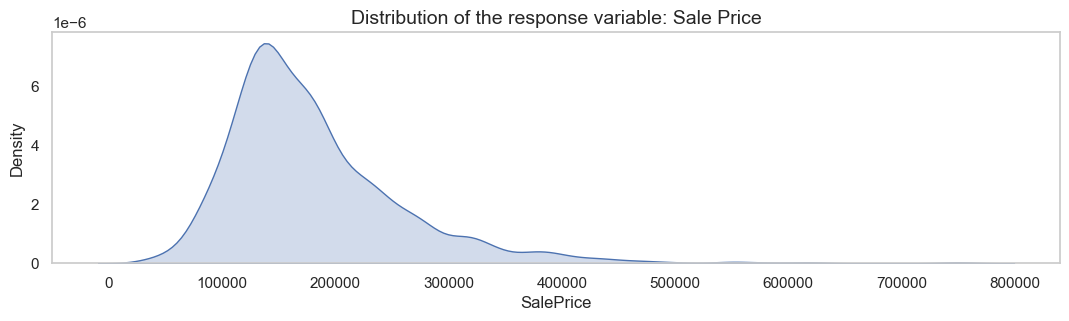

In [483]:
sns.set(rc = {'figure.figsize':(13,3)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.kdeplot(data=train, x="SalePrice", bw_adjust=.8, fill=True)\
    .set_title("Distribution of the response variable: Sale Price", size=14)
print("")

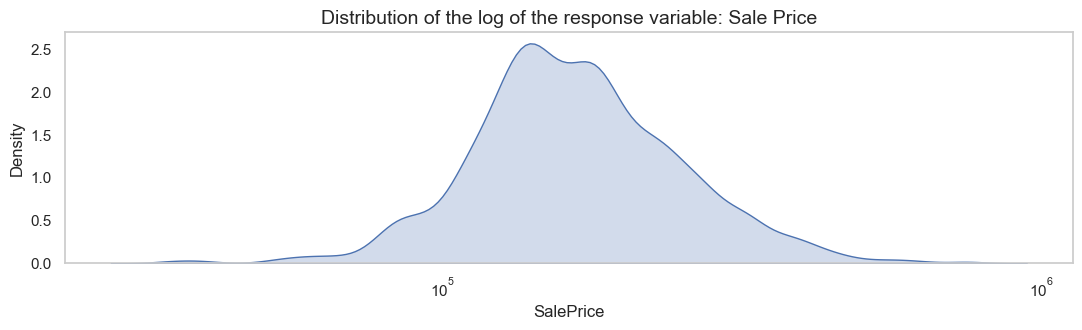

In [484]:
sns.set(rc = {'figure.figsize':(13,3)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.kdeplot(data=train, x="SalePrice", bw_adjust=.8, fill=True, log_scale=True)\
    .set_title("Distribution of the log of the response variable: Sale Price", size=14)
print("")

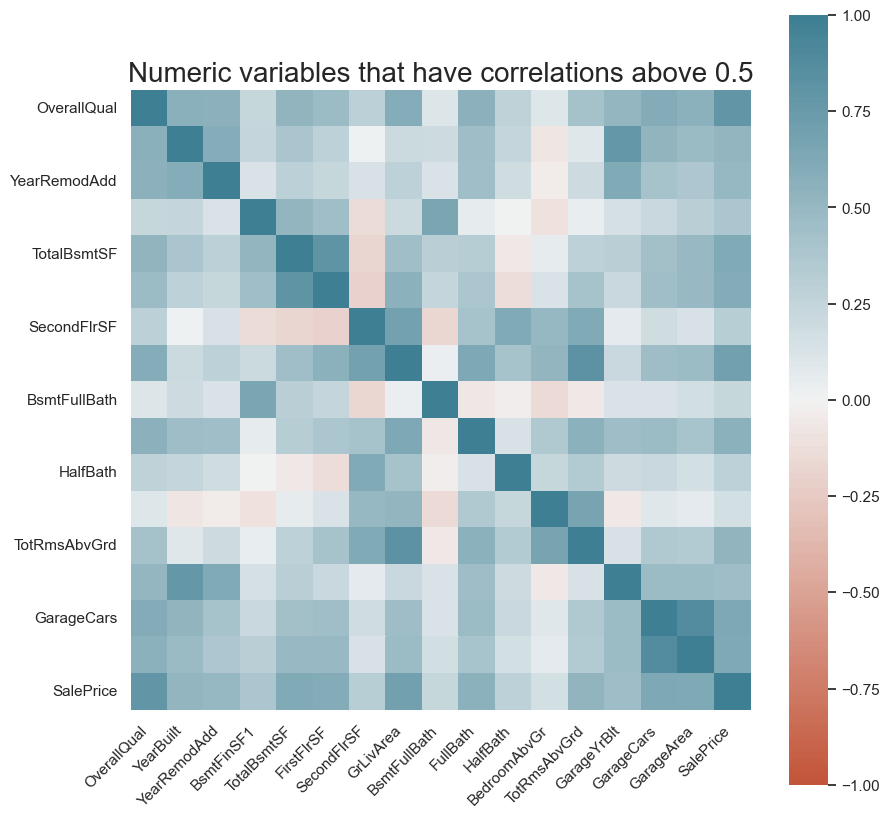

In [485]:
# get correlations of all numeric vars
corr_orig = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].corr()

# there are 38 of them, let's look at a subset to only show the ones w/ correlations above .5
threshold = .5
bool_list = [sum((corr_orig.iloc[i,:] < 1) & (corr_orig.iloc[i,:] > threshold)) > 0 for i in range(corr_orig.shape[0])]
corr = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].loc[:, bool_list].corr()

# plot the results
sns.set()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Numeric variables that have correlations above {:.1f}".format(threshold), fontdict = {"fontsize": 20})

plt.gcf().set_size_inches(10, 10)
print("")

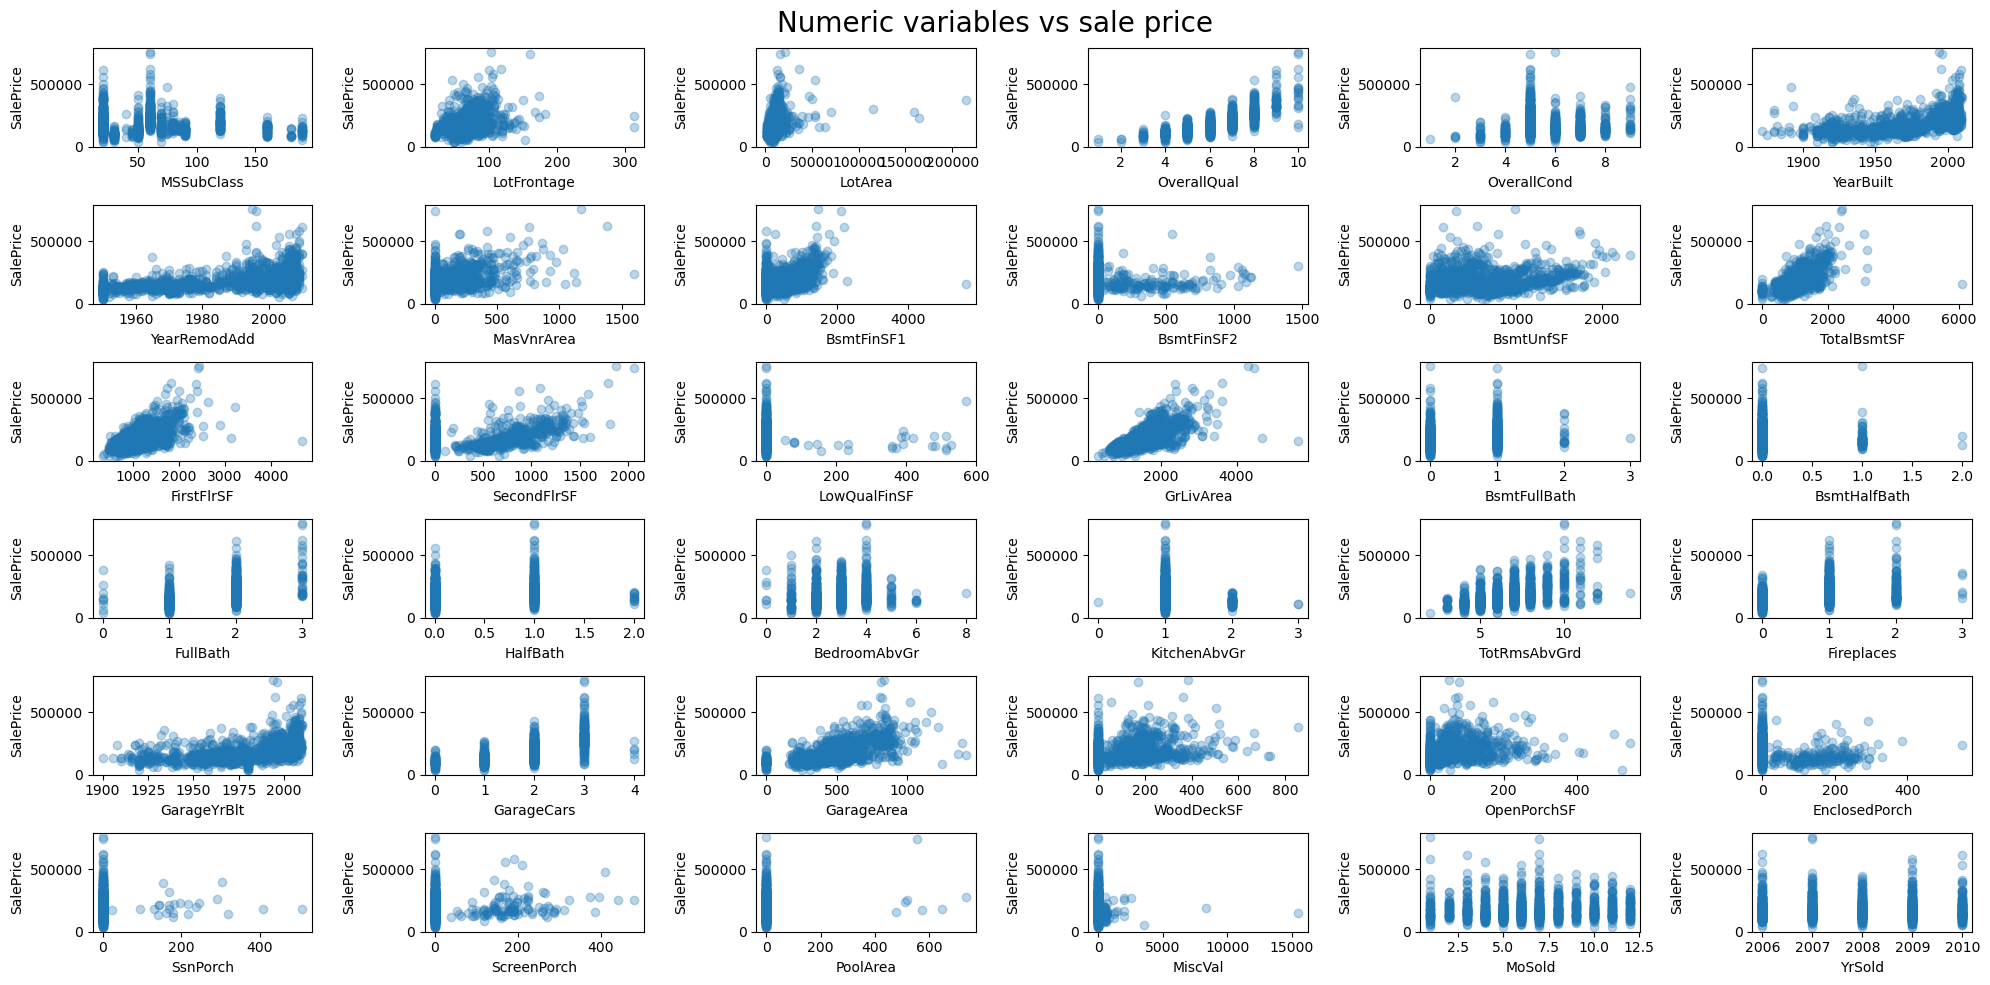

In [456]:
# scatter plots of all num vars w/ response var
num_vars = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))]
num_vars = num_vars.drop(columns = ["Id"])

# plot in 6x6 grid to plot the 36 num vars against SalePrice
num_rows = 6
num_cols = 6
plt.style.use('default')
fig, ax = plt.subplots(num_rows, num_cols, figsize = (20, 10))

col_i = 0
for i in range(num_rows):
    for j in range(num_cols):
        if (num_vars.columns[col_i] == "SalePrice"):
            pass 
        else:
            ax[i][j].scatter(num_vars.iloc[:, col_i], num_vars['SalePrice'], alpha = .3)
            ax[i][j].set_xlabel(num_vars.columns[col_i])
            ax[i][j].set_ylabel("SalePrice")
            
            col_i += 1

fig.suptitle("Numeric variables vs sale price".format(col_i), size=20)
fig.tight_layout()
print("")

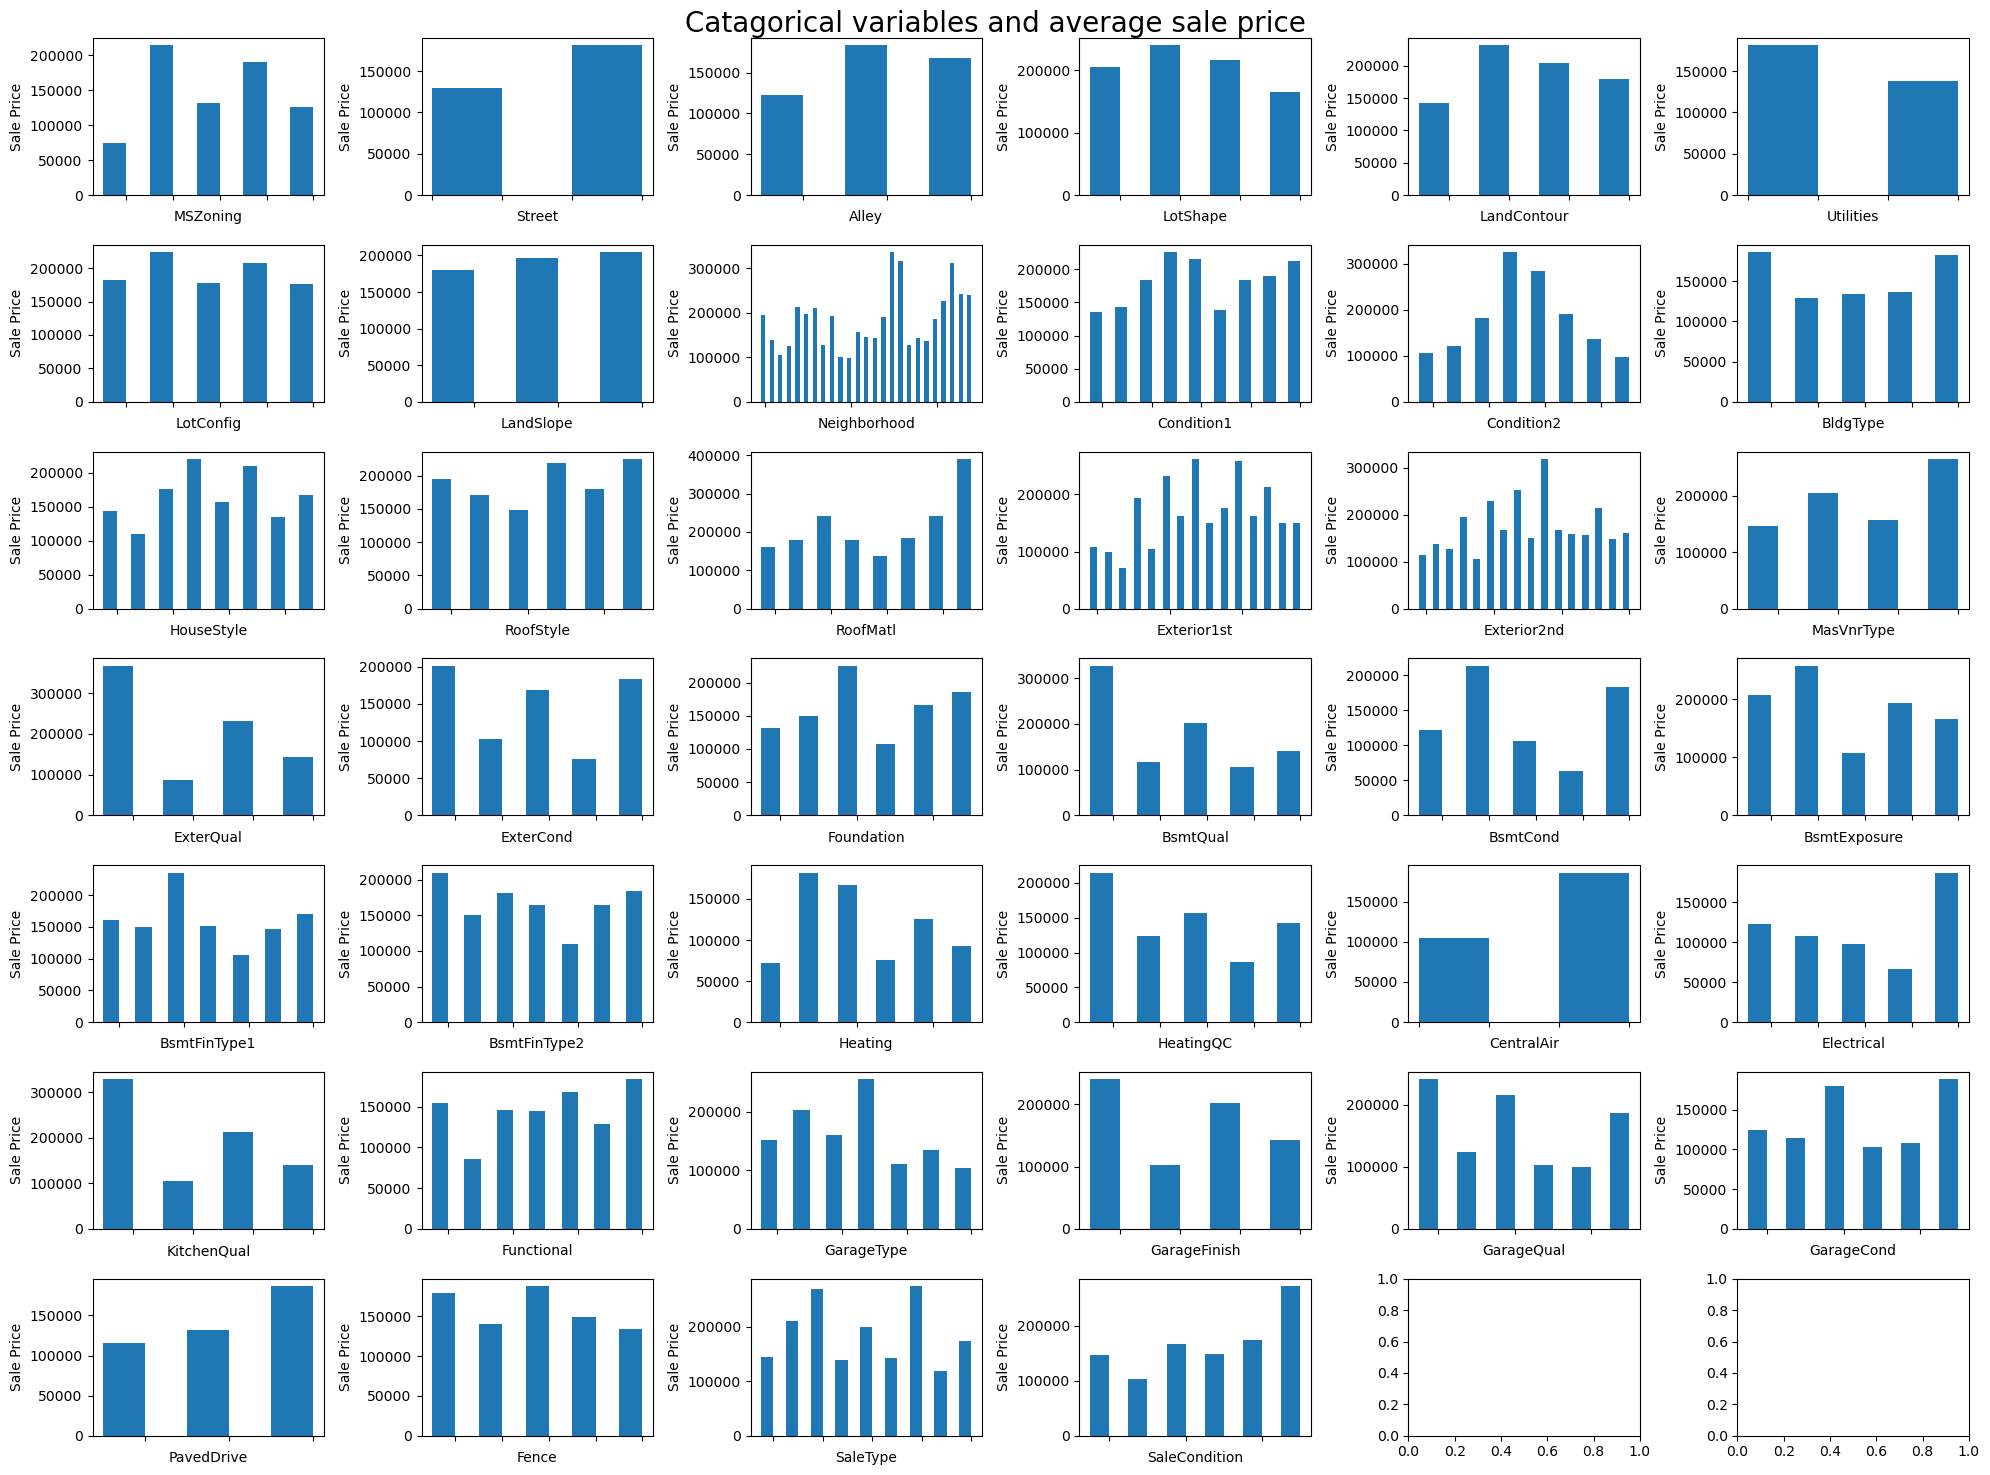

In [464]:
# categorical exploration
cat_vars = pd.concat([train.loc[:, train.dtypes == type(train.dtypes[2])], train.SalePrice], axis = 1)
n_cols = cat_vars.shape[1]

# plots
num_row = 7
num_col = 6
fig, ax = plt.subplots(num_row, num_col, figsize = (20, 15))

count_k = 0
for i in range(num_row):
    for j in range(num_col):

        # each df
        var_i = cat_vars.columns[count_k]

        if var_i == "SalePrice":
            pass 
        else:

            df_i = pd.DataFrame(cat_vars.groupby(var_i)['SalePrice'].mean())
            df_i.reset_index(inplace = True)

            # create plot i
            x = np.arange(df_i.shape[0])
            width = .5

            # set the bars
            ax[i][j].bar(x - width / 2, df_i.SalePrice, width, label = "x")
            ax[i][j].set_xlabel(var_i)
            ax[i][j].set_ylabel("Sale Price")
            #ax[i][j].set_xticklabels(df_i[var_i], rotation = 90)
            ax[i][j].set_xticklabels("")
            
            count_k += 1

fig.suptitle("Catagorical variables and average sale price", size=20)
fig.tight_layout()

print("")

# Modeling

## Lasso

In [491]:
# start w/ lasso regression to narrow down the variable list
# I'm not doing this right and am running into issues, fix this later...
# read more about standardizing/normalizing the features before. 

# get log of sale price
train['LogSalePrice'] = np.log(train.SalePrice)

# get all variables
lasso_vars = list(train.loc[:, "MSSubClass":"SaleCondition"].columns)
# remove vars that don't look impactful graphically, or have too many missing values
vars_i_dont_want = ["LowQualFinSF", "PoolQC", "Fence", "MiscFeature", "FireplaceQu", "SalePrice"]
lasso_vars = list(np.array(lasso_vars)[np.array([lasso_vars[i] not in vars_i_dont_want for i in range(len(lasso_vars))])])
lasso_vars.sort()
lasso_vars = "+".join(lasso_vars)
formula = "LogSalePrice~" + lasso_vars

# build one hot encoded matrices
y, X = dmatrices(formula, data = train, return_type = "dataframe")

# train the lasso model
lasso = Lasso(tol = .0001, max_iter = 5000)

# cross validate for optimal alpha (weight for penalty on additional betas in loss function)
grid = {'alpha': np.arange(0.0, .1, .01)}

gscv = GridSearchCV(
    estimator = lasso, 
    param_grid = grid, 
    #scoring = 'neg_mean_absolute_error',
    n_jobs = -1, # n jobs to run in parallel. 1 = none, -1 = use all processors
    cv = 5 # 5 cross folds
    )

# fit model using all alpha's I specified
results = gscv.fit(X, y)

# optimal alpha level
print("Optimal alpha level: {}".format(results.best_params_['alpha'])) # 0.01

# plug in this alpha parameter for final lasso regression
lasso_final = Lasso(alpha = results.best_params_['alpha'], tol = .0001, max_iter = 5000)
lasso_final.fit(X, y)

# see coefficents that are greater than some threshold
coef_threshold = 0
lasso_results_df = pd.DataFrame({
    'final_features': np.array(X.columns)[np.array(lasso_final.coef_) > coef_threshold],
    'final_coefs': np.array(lasso_final.coef_)[np.array(lasso_final.coef_) > coef_threshold]
})
print(lasso_results_df) 

Optimal alpha level: 0.01
   final_features  final_coefs
0      BsmtFinSF1     0.000064
1      BsmtFinSF2     0.000045
2   EnclosedPorch     0.000178
3      Fireplaces     0.019853
4      FirstFlrSF     0.000039
5      GarageArea     0.000227
6       GrLivArea     0.000221
7         LotArea     0.000002
8     OverallCond     0.035494
9     OverallQual     0.080800
10    ScreenPorch     0.000428
11    SecondFlrSF     0.000032
12       SsnPorch     0.000229
13   TotRmsAbvGrd     0.001944
14    TotalBsmtSF     0.000047
15     WoodDeckSF     0.000160
16      YearBuilt     0.003546
17   YearRemodAdd     0.001830


## GLM with Gamma family

In [500]:
# Now w/ narrowed down variable list, build a glm w/ gamma family due to sale price dist shape
lasso_vars_list = list(lasso_results_df['final_features'])
lasso_vars_list = "+".join(lasso_vars_list)

glm_formula = "LogSalePrice~" + lasso_vars_list
fit_glm = glm(glm_formula, data = train, family = sm.families.Gamma(sm.families.links.log))
fit_glm = fit_glm.fit()
print(fit_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           LogSalePrice   No. Observations:                 1460
Model:                            GLM   Df Residuals:                     1441
Model Family:                   Gamma   Df Model:                           18
Link Function:                    log   Scale:                      0.00015775
Method:                          IRLS   Log-Likelihood:                 676.48
Date:                Sun, 03 Oct 2021   Deviance:                      0.23428
Time:                        14:56:05   Pearson chi2:                    0.227
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5692      0.043     36.812

<ipython-input-500-5207b2b38d3e>:6: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  fit_glm = glm(glm_formula, data = train, family = sm.families.Gamma(sm.families.links.log))


In [131]:
# random forest

In [132]:
# boosted tree

In [133]:
# neural net??

In [134]:
# any other model?

## Best Model